In [2]:
! nvidia-smi

Sat May  6 12:35:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    30W /  70W |   9041MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [3]:
from spellbook.parallel import get_experiment_name

from train_pipeline import train, _train_seed

import os
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf


def load_cfg(overrides=()):
    # with initialize_config_dir(config_dir="/app/notebooks/draft_02/conf"):
    with initialize(version_base=None, config_path="./conf"):
        cfg = compose(config_name='config', overrides=list(overrides))
        return cfg

from IPython.display import clear_output

cfg = load_cfg(overrides=[
    "+exp=04_parallel",
    "model.model_configs=[{hidden_layers: [64]}]",
    "+device=cuda:0",
])

cfg.logging.experiment_name = get_experiment_name(cfg)

print(OmegaConf.to_yaml(cfg))

image: sasha.jpg
image_dir: ../../data
image_W: 512
use_wandb: true
is_debug: false
total_steps: 3000
random_seed:
- 0
- 1
- 2
- 3
- 4
model:
  _target_: spellbook.parallel.ParallelSplitNet
  encoding_size: 64
  model_configs:
  - hidden_layers:
    - 64
logging:
  logger:
    _target_: spellbook.logging.wandb.WandbLogger
    project: 01_splitnet__${image}
  steps_till_summary: 500
  experiment_name: parallel_splitnet__[128],64
optimizer:
  _target_: torch.optim.AdamW
  weight_decay: 0.0
  lr: 0.0001
device: cuda:0



Setting seed to 0


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kilianovski. Use `wandb login --relogin` to force relogin


********************************************************************************


image: sasha.jpg
image_dir: ../../data
image_W: 512
use_wandb: true
is_debug: false
total_steps: 3000
random_seed:
- 0
- 1
- 2
- 3
- 4
model:
  _target_: spellbook.parallel.ParallelSplitNet
  encoding_size: 64
  model_configs:
  - hidden_layers:
    - 64
logging:
  logger:
    _target_: spellbook.logging.wandb.WandbLogger
    project: 01_splitnet__${image}
  steps_till_summary: 500
  experiment_name: parallel_splitnet__[128],64
optimizer:
  _target_: torch.optim.AdamW
  weight_decay: 0.0
  lr: 0.0001
device: cuda:0


********************************************************************************
+--------------------------------+------------+
|            Modules             | Parameters |
+--------------------------------+------------+
| networks.0.net.0.linear.weight |   32768    |
|  networks.0.net.0.linear.bias  |    256     |
|    networks.0.net.1.weight     |    192     |
|     networks.0.net.1.bi

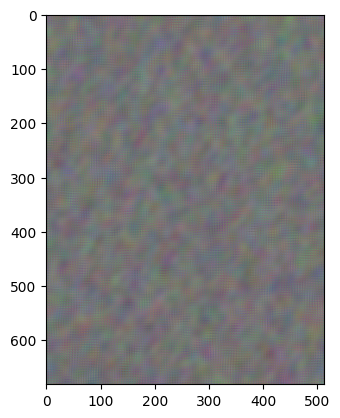

Step 500, Total loss 0.056135


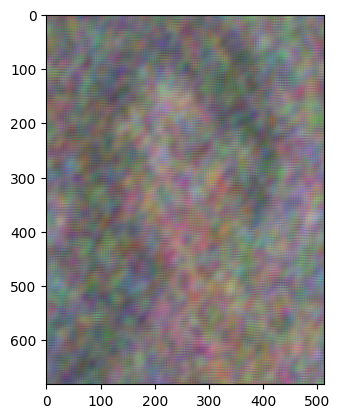

Step 1000, Total loss 0.029073


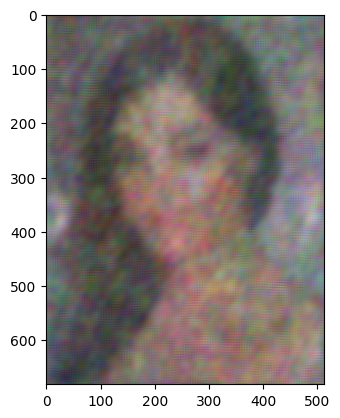

Step 1500, Total loss 0.013029


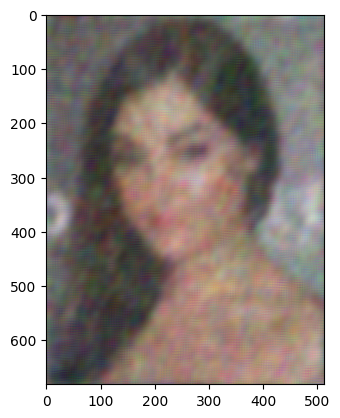

Step 2000, Total loss 0.007335


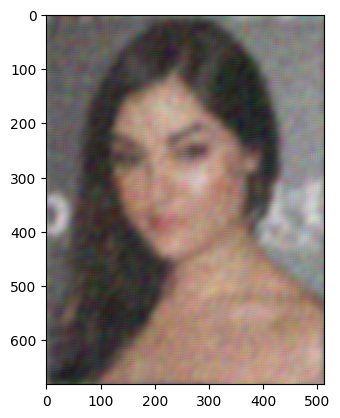

Step 2500, Total loss 0.005218


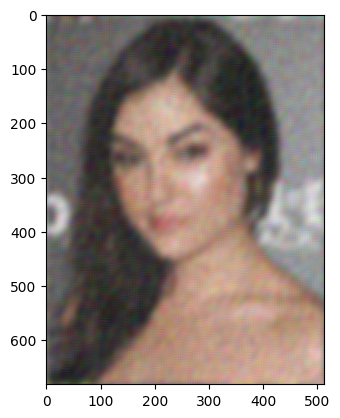

In [4]:
model = _train_seed(cfg, 0)

In [55]:
W = instantiate(cfg.model, out_features=3).networks[0].net[0].linear.weight.data[:64]
torch.det(W@W.T)

tensor 3.601e-40

In [26]:
net = model.networks[0]

In [33]:
W = net.net[0].linear.weight.data[:64]

In [34]:
W

tensor[64, 128] n=8192 x∈[-0.309, 0.322] μ=0.000 σ=0.090 cuda:0

In [37]:
import torch

In [40]:
u,s,v = torch.svd(W@W.T)
s

tensor[64] x∈[0.090, 3.305] μ=1.042 σ=0.845 cuda:0

tensor cuda:0 3.371e-10

In [47]:
I = torch.eye(64)
I[0] = 0.01
I

tensor[64, 64] n=4096 x∈[0., 1.000] μ=0.016 σ=0.123

In [48]:
u,s,v = torch.svd(I)
s

tensor[64] x∈[0.010, 1.003] μ=0.985 σ=0.124

In [19]:
from spellbook.splitnet import U, plot_acts
from torch import nn

In [15]:
x = U(2000, 2).to(cfg.device)

x = model.encoding(x)
h = x
intermediate_acts = []

for layer in net.net:
    if not isinstance(layer, nn.Linear):
        h, acts = layer.forward_with_activations(h)
    else:
        h = layer(h)
        acts = []

    intermediate_acts.append((h, acts))

In [22]:
acts[1]

[tensor[2000, 128] n=256000 x∈[-1.000, 1.000] μ=-0.003 σ=0.707 cuda:0,
 tensor[2000, 256] n=512000 x∈[-4.462, 5.088] μ=0.023 σ=0.859 grad AddmmBackward0 cuda:0,
 tensor[2000, 64] n=128000 x∈[-3.503, 3.260] μ=-0.011 σ=0.733 grad SplitBackward0 cuda:0,
 tensor[2000, 64] n=128000 x∈[-4.462, 5.088] μ=0.111 σ=1.040 grad SplitBackward0 cuda:0,
 tensor[2000, 64] n=128000 x∈[-3.236, 3.037] μ=-0.017 σ=0.724 grad SplitBackward0 cuda:0,
 tensor[2000, 64] n=128000 x∈[-3.993, 3.915] μ=0.007 σ=0.893 grad SplitBackward0 cuda:0,
 tensor[2000, 64] n=128000 x∈[-0.998, 0.997] μ=-0.008 σ=0.533 grad TanhBackward0 cuda:0,
 tensor[2000, 64] n=128000 x∈[0.011, 0.994] μ=0.522 σ=0.213 grad SigmoidBackward0 cuda:0,
 tensor[2000, 64] n=128000 x∈[-1.000, 1.000] μ=-0.012 σ=0.569 grad SinBackward0 cuda:0,
 tensor[2000, 64] n=128000 x∈[-1.000, 1.000] μ=0.672 σ=0.390 grad CosBackward0 cuda:0]

h tensor[2000, 64] n=128000 x∈[-0.875, 0.893] μ=-0.011 σ=0.153 grad MulBackward0 cuda:0


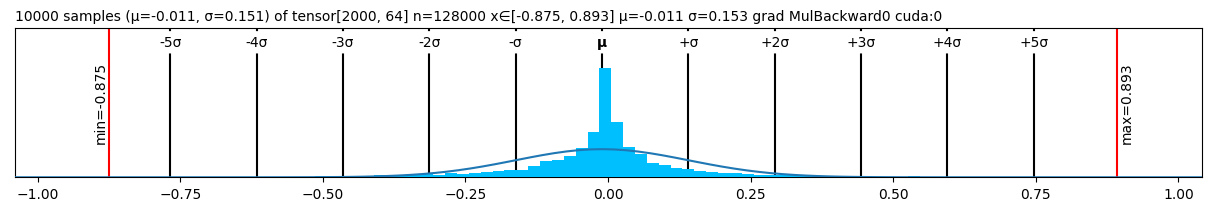

act_tanh (2000, 64) in [-0.998, 0.997] μ=-0.008 σ=0.533
act_sigmoid (2000, 64) in [0.011, 0.994] μ=0.522 σ=0.213
act_sin (2000, 64) in [-1.000, 1.000] μ=-0.012 σ=0.569
act_cos (2000, 64) in [-1.000, 1.000] μ=0.672 σ=0.390


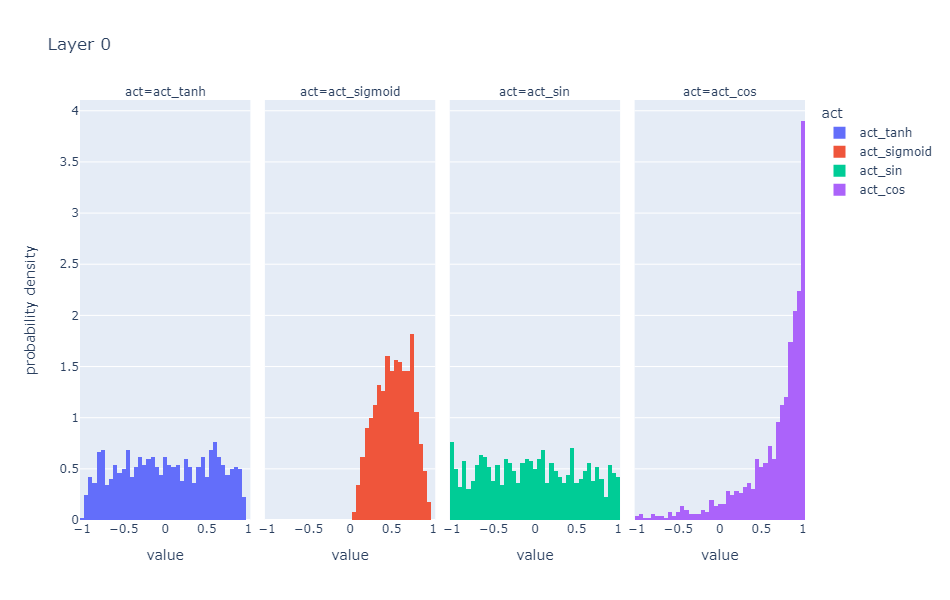

h tensor[2000, 3] n=6000 x∈[-0.078, 0.966] μ=0.422 σ=0.246 grad AddmmBackward0 cuda:0


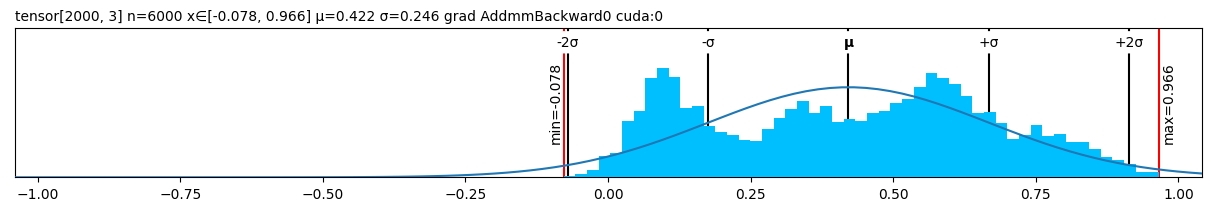

ValueError: not enough values to unpack (expected 10, got 0)

In [25]:
for i, (h, acts) in enumerate(intermediate_acts):
    print('h', h)
    display(h.plt)
    plot_acts(acts, f'Layer {i}')
    

In [ ]:
def forward_with_activations(self, x):
    x = self.encoding(x)
    h = x
    intermediate_acts = []

    for layer in net:
        if isinstance(layer, SplitLayerOmegas):
            h, acts = layer.forward_with_activations(h)
        else:
            h = layer(h)
            acts = []

        intermediate_acts.append((h, acts))

    return h, intermediate_acts